In [1]:
import numpy as np
from calibration import CalibrationSystem, SparseModel
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from calibration.errormetrics import MAE, MSE, NMSE, NLPD, compute_test_data
from calibration.synthetic import generate_synthetic_dataset, getstaticsensortranform, getmobilesensortranform

In [2]:
Nstatic = 10
Nmobile = 4
Ttotal = 24*180
Nrefs = 4
Nvisitsperdayref = 0.5
Nvisitsperday = 2.5
staticsensornoise = 10
mobilesensornoise = 10
Nsamps = 1
refsensor,X,Y,trueY,statics,mobilecentres = generate_synthetic_dataset(Nstatic, Nmobile, Ttotal, Nrefs, Nvisitsperdayref, Nvisitsperday, staticsensornoise, mobilesensornoise, Nsamps)

(-0.040367162515694, 0.9759727816371875, 0.09750210950094, 1.0087377186071402)

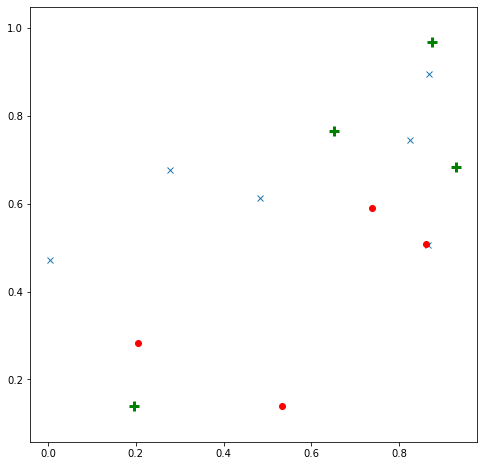

In [3]:
plt.figure(figsize=[8,8])
plt.plot(statics[:Nrefs,0],statics[:Nrefs,1],'+g',markersize=10,mew=3)
plt.plot(statics[Nrefs:,0],statics[Nrefs:,1],'x')
plt.plot(mobilecentres[:,0],mobilecentres[:,1],'ro')
plt.axis('equal')

# Applying our Method

A hacky experiment to encourage reference data to be used more...
otherwise most minibatches won't include any reference signal?
is this really dubious...?

In [4]:
refencounters = np.any(np.isin(X[:,1:],np.where(refsensor)[0]),1)
augmentedX = np.r_[X,np.repeat(X[refencounters,:],10,0)]
augmentedY = np.r_[Y,np.repeat(Y[refencounters,:],10,0)]

In [5]:
Z = np.linspace(-200,Ttotal+200,60)[:,None] ##60

In [6]:
def transform_fn(samps,Y,sideY):
    return Y*tf.exp(samps[:,:,0:1])
kernelindices = [[0]*Nstatic+[1]*Nmobile]

## Hyperparameter Search

In [7]:
np.logspace(np.log(24*5),np.log(24*500),10,base=np.e)/24

array([  5.        ,   8.34050269,  13.91279701,  23.20794417,
        38.71318413,  64.57748325, 107.7217345 , 179.69068319,
       299.74212516, 500.        ])

In [59]:
for staticls in np.logspace(np.log(24*5),np.log(24*500),20,base=np.e):
    for mobilels in np.logspace(np.log(24*5),np.log(24*500),20,base=np.e):
        for likelihoodstd in np.logspace(np.log(1),np.log(50),5,base=np.e):
            kstatic = gpflow.kernels.RBF(5.0,staticls) + gpflow.kernels.Bias(1.5)
            kmobile = gpflow.kernels.RBF(5.0,mobilels) + gpflow.kernels.Bias(1.5)
            cs = CalibrationSystem(augmentedX, augmentedY, Z, refsensor, 1, transform_fn, [kstatic,kmobile], kernelindices,lr=0.01,likelihoodstd=likelihoodstd,minibatchsize=50)
            import time
            before = time.time()
            print("Starting Run")
            elbo_record = cs.run(400,samples=200) ##3000 iterations, 300 samples
            print(time.time()-before)

            testX, testY, testtrueY = compute_test_data(X,Y,trueY,refsensor)

            testsm = SparseModel(testX,cs.Z,C,cs.k)
            qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
            #qf_mu=qf_mu*0
            predY = transform_fn(qf_mu[None,:,:],testY[:,0:1],None).numpy()[:,:,0].T
            #predY[predY>100]=100
            nlpd = NLPD(np.log(testtrueY),np.log(testY[:,0:1])+qf_mu,np.sqrt(np.diag(qf_cov))[:,None])
            nmse = NMSE(testtrueY,predY)
            mse = MSE(testtrueY,predY)
            mae = MAE(testtrueY,predY)
            print("staticls=%5.2f, mobilels=%5.2f likelihoodstd=%5.2f: nlpd=%5.2f nmse=%5.2f mse=%5.2f mae=%5.2f" % (staticls,mobilels,likelihoodstd,nlpd,nmse,mse,mae))

Starting Run
Starting Run
....................20 (ELBO=17758386176.0000)
....................40 (ELBO=9877798912.0000)
....................60 (ELBO=4343549440.0000)
....................80 (ELBO=1420594688.0000)
....................100 (ELBO=970005056.0000)
....................120 (ELBO=482293568.0000)
....................140 (ELBO=453984000.0000)
....................160 (ELBO=345288032.0000)
....................180 (ELBO=502616800.0000)
....................200 (ELBO=282404928.0000)
....................220 (ELBO=399345888.0000)
....................240 (ELBO=307947968.0000)
....................260 (ELBO=450935104.0000)
....................280 (ELBO=208514208.0000)
....................300 (ELBO=251658672.0000)
....................320 (ELBO=254948688.0000)
....................340 (ELBO=119339448.0000)
....................360 (ELBO=156873216.0000)
....................380 (ELBO=179465648.0000)
....................400 (ELBO=150462528.0000)
118.71811032295227
staticls=120.00, mobilels=120.00 l

KeyboardInterrupt: 

In [8]:
#this seems to work ok.
kstatic = gpflow.kernels.RBF(5.0,24*40) + gpflow.kernels.Bias(1.5)
kmobile = gpflow.kernels.RBF(5.0,24*12) + gpflow.kernels.Bias(1.5)
cs = CalibrationSystem(augmentedX, augmentedY, Z, refsensor, 1, transform_fn, [kstatic,kmobile], kernelindices,lr=0.01,likelihoodstd=10.0,minibatchsize=50)
import time
before = time.time()
print("Starting Run")
elbo_record = cs.run(1000,samples=200) ##3000 iterations, 300 samples
print(time.time()-before)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Starting Run
Starting Run
....................20 (ELBO=5627139.5000)
....................40 (ELBO=2744400.0000)
....................60 (ELBO=1549145.3750)
....................80 (ELBO=1002090.3125)
....................100 (ELBO=696097.3125)
....................120 (ELBO=492446.3438)
....................140 (ELBO=375073.2500)
....................160 (ELBO=298613.7188)
....................180 (ELBO=238534.0938)
....................200 (ELBO=195447.1094)
....................220 (ELBO=172561.4688)
....................240 (ELBO=150443.9688)
....................260 (ELBO=148616.8906)
....................280 (ELBO=122070.6719)
....................300 (ELBO=100998.2578)
....................320 (ELBO=98425.7812)
....................340 (ELBO=82244.6094)
....................360 (ELBO=78097.5625)
....................380 (ELBO

## Compute Chosen Config

In [43]:
#kstatic = gpflow.kernels.RBF(5.0,24*40) + gpflow.kernels.Bias(1.5)
#kmobile = gpflow.kernels.RBF(5.0,24*12) + gpflow.kernels.Bias(1.5)
#cs = CalibrationSystem(augmentedX, augmentedY, Z, refsensor, 1, transform_fn, [kstatic,kmobile], kernelindices,lr=0.02,likelihoodstd=25,minibatchsize=100)
#import time
#before = time.time()
#print("Starting Run")
#elbo_record = cs.run(50,samples=300) ##3000 iterations, 300 samples
#print(time.time()-before)

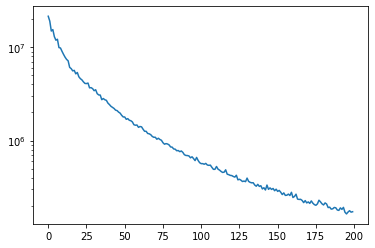

In [44]:
plt.plot(elbo_record)
plt.yscale('log')

# Simple Effort

For comparison we run a simple version to try to generate calibration predictions too.

In [45]:
from calibration.simple import compute_simple_solution,plotbars,compute_simple_predictions
from calibration.errormetrics import compute_test_data

delta = 24*10
allscales = compute_simple_solution(X,Y,refsensor,delta)

testX, testY, testtrueY = compute_test_data(X,Y,trueY,refsensor)

# Plot

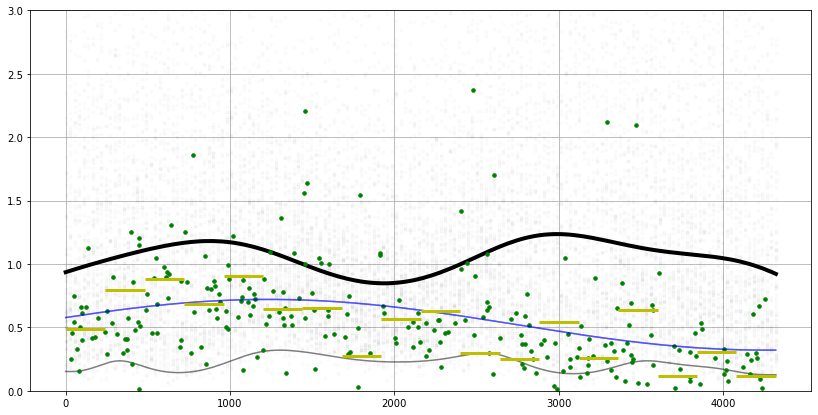

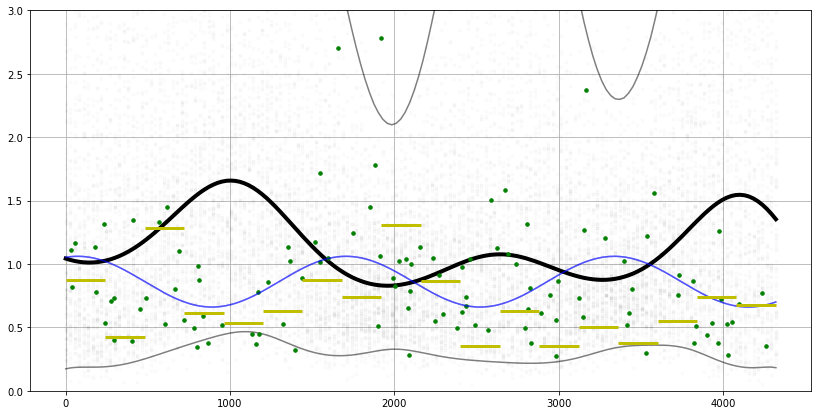

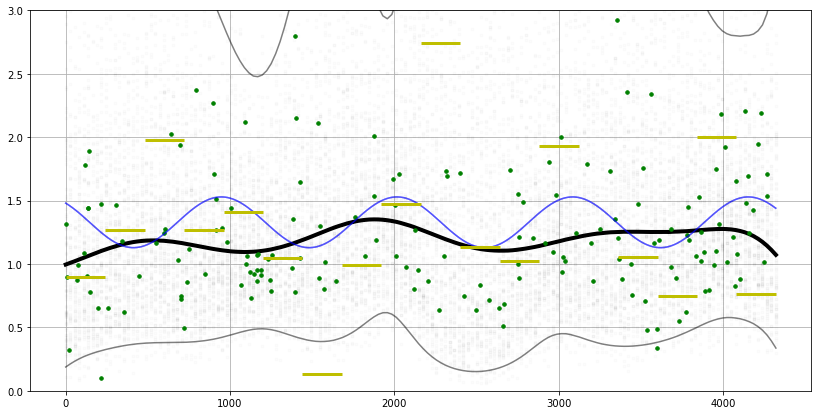

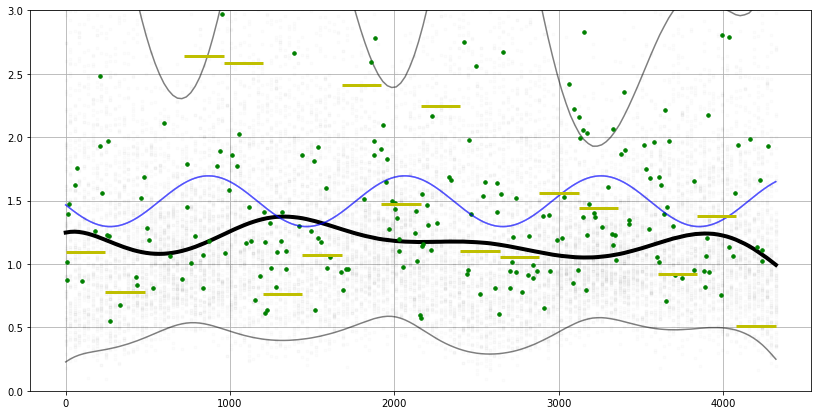

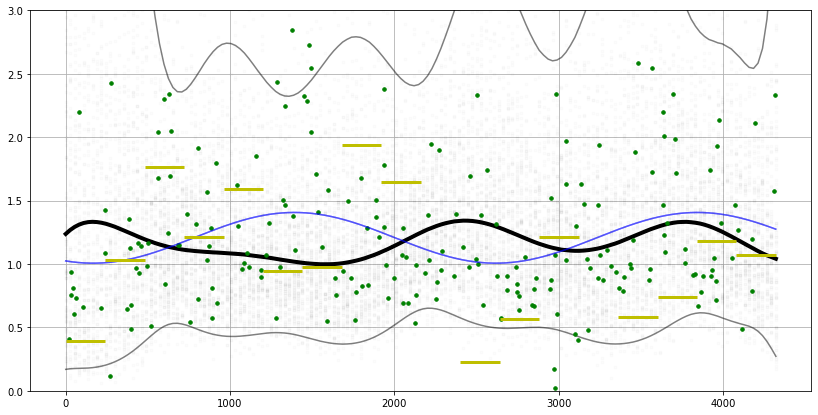

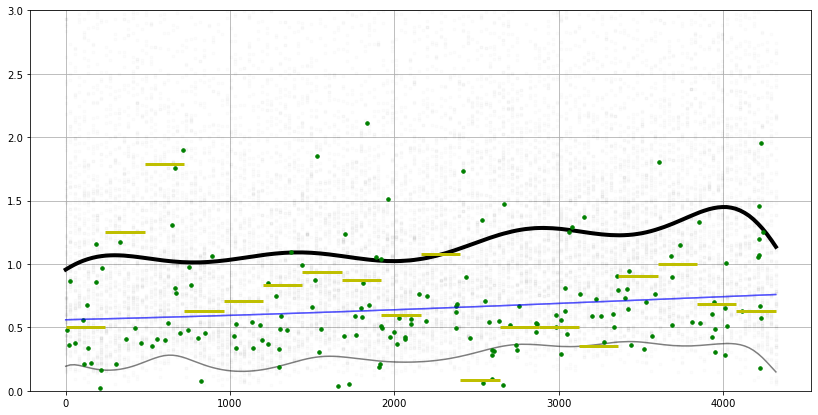

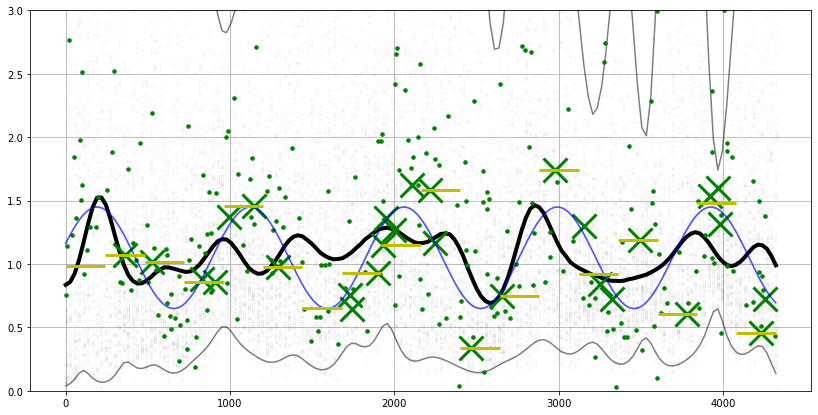

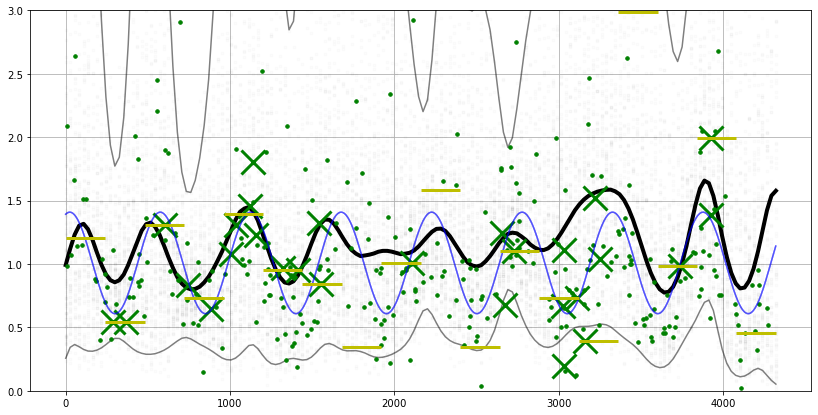

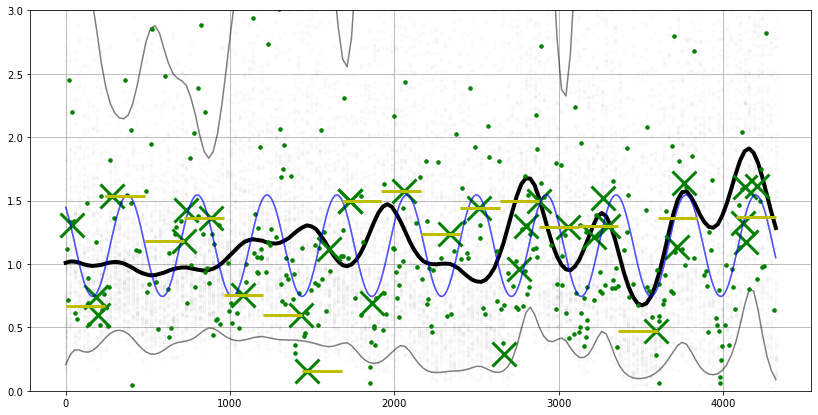

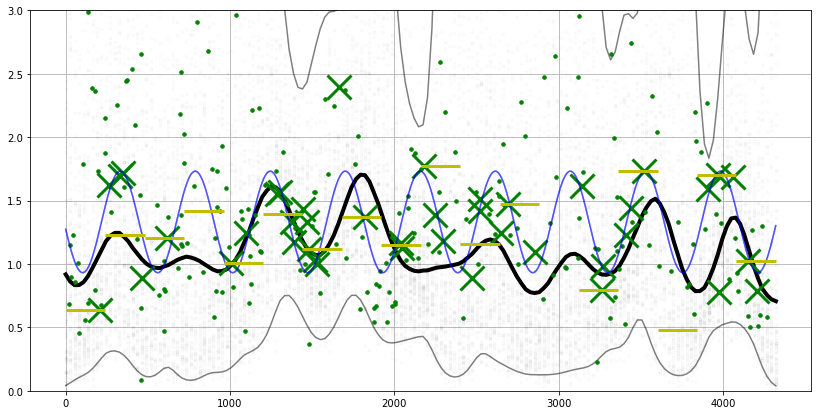

In [46]:
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,Ttotal,160)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[14,7])
    plt.plot(x,1/tf.exp(qf_mu[:,0]),'k-',lw=4)
    plt.plot(x,1/np.exp(samps[:,:,0].numpy().T),'k.',alpha=0.01);
    
    plt.plot(x,1/tf.exp((qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)

    senseX = (X[:,1]==si) & (X[:,2]<Nrefs)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xg',markersize=24,mew=3)
    
    
        
    senseX = (X[:,2]==si) & (X[:,1]<Nrefs)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xg',markersize=24,mew=3)
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'.g',markersize=7)
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'.g',markersize=7)    
    plotbars(np.arange(0,np.max(X[:,0]),delta),delta,np.exp(allscales[:,si]),'y')
    plt.ylim([0,3])
    #plt.yscale('log')
    plt.grid()
    if si<Nstatic:
        for samp in range(10):
            plt.plot([(getstaticsensortranform(t,100.0,Nrefs,si,noisescale=0)/100) for t in np.arange(Ttotal)],'b-',alpha=0.1)
    else:
        for samp in range(10):
            plt.plot([(getmobilesensortranform(t,100.0,si-Nstatic,noisescale=0)/100) for t in np.arange(Ttotal)],'b-',alpha=0.1)

In [47]:
testX, testY, testtrueY = compute_test_data(X,Y,trueY,refsensor)
    
testsm = SparseModel(testX,cs.Z,C,cs.k)
qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
#qf_mu=qf_mu*0
predY = transform_fn(qf_mu[None,:,:],testY[:,0:1],None).numpy()[:,:,0].T
#predY[predY>100]=100

nlpd = NLPD(np.log(testtrueY),np.log(testY[:,0:1])+qf_mu,np.sqrt(np.diag(qf_cov))[:,None])
nmse = NMSE(testtrueY,predY)
mse = MSE(testtrueY,predY)
mae = MAE(testtrueY,predY)
print("nlpd=%5.2f nmse=%5.2f mse=%5.2f mae=%5.2f" % (nlpd,nmse,mse,mae))

nlpd= 0.85 nmse= 0.13 mse=440.36 mae=16.18


In [49]:
simple_predY = compute_simple_predictions(testX,testY,allscales,delta)
simple_predY[simple_predY>100]=100
#simple_predY = 0*simple_predY + np.mean(testY)
nmse = NMSE(testtrueY,simple_predY)
mse = MSE(testtrueY,simple_predY)
mae = MAE(testtrueY,simple_predY)
print("nlpd=N/A   nmse=%5.2f mse=%5.2f mae=%5.2f" % (nmse,mse,mae))

nlpd=N/A   nmse= 0.16 mse=576.63 mae=20.76


(0.0, 200.0)

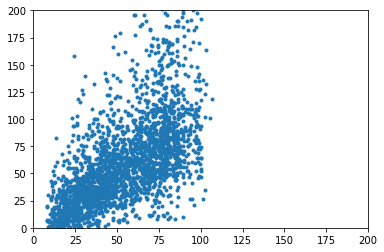

In [30]:
plt.plot(testtrueY,simple_predY,'.')
plt.ylim([0,200])
plt.xlim([0,200])


(0.0, 200.0)

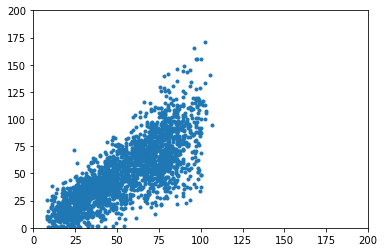

In [31]:
plt.plot(testtrueY,predY,'.')
plt.ylim([0,200])
plt.xlim([0,200])